In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

%matplotlib inline

In [2]:
def initMatrices(dim, num):
    # Initial guesses for h and vi
    h = np.ones((dim, dim)) * 128
    v = np.ones((num, dim, dim)) * 128
    return h, v

In [ ]:
# sgn(xi)max(0,|xi|−τ)
 
def calc_soft_thresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)


In [3]:
# Now vk is a 3 dimensional array, H is still 2D
def calcA_v(H, vk):
    H3 = np.tile(H, (np.shape(vk)[0], 1, 1))
    Vk = fft.fft2(fft.ifftshift(vk, axes = (1, 2)))
    return fft.fftshift(fft.ifft2(H3*Vk), axes = (1, 2))

def calcAHerm_v(Hadj, diff):
    xpad = diff
    X = fft.fft2(fft.ifftshift(xpad, axes = (1, 2)))
    return fft.fftshift(fft.ifft2(Hadj*X), axes = (1, 2))

def calcA_h(V, h):
    H = fft.fft2(fft.ifftshift(h))
    H3 = np.tile(H, (np.shape(V)[0], 1, 1))
    return fft.fftshift(fft.ifft2(H3*V), axes = (1, 2))

def calcAHerm_h(Vadj, diff):
    xpad = diff
    X = fft.fft2(fft.ifftshift(xpad, axes = (1, 2)))
    return np.sum(fft.fftshift(fft.ifft2(Vadj*X), axes = (1, 2)), axis = 0)


In [42]:
def calc_loss_h(H, v, b):
    return calcA_v(H, v) - b
    
def calc_loss_v(V, h, b):
    return calcA_h(V, h) - b

def calc_sum_sq(v):
    return np.abs(np.sum(v**2))
    
def gd_update(iterations, alpha_v, alpha_h, b, h, v):
    # _, v = initMatrices(800, 4)
    h, _ = initMatrices(800, 4)
    
    # uncomment when only running derivative with h
    V = fft.fft2(fft.ifftshift(v, axes = (1, 2)))
    Vadj = np.conj(V)
    
    for i in range(iterations):
        if i % 10 == 0:
            print(str(i) + "th iteration")
            print('loss: ' + '{:.2e}'.format(calc_sum_sq(calc_loss_v(V, h, b))))
            
        '''
        # derivative w.r.t. v
        H = fft.fft2(fft.ifftshift(h))
        Hadj = np.conj(H)
        loss_v = calc_loss_h(H, v, b)
        v = v - alpha_v * np.real(calcAHerm_v(Hadj, loss_v))
        v = np.maximum(v, 0)
        # derivative w.r.t. h
        '''
        # V = fft.fft2(fft.ifftshift(v, axes = (1, 2)))
        # Vadj = np.conj(V)
        h = h - alpha_h * np.real(calcAHerm_h(Vadj, calcA_h(V, h) - b))
        h = np.maximum(h, 0)
        
    return h, v

In [43]:
def generate_single_b(h, v = None, num_points = 5):
    # generate light source with num_points
    if np.any(v) == None:
        v = np.zeros((800,800))
        points = np.random.randint(low=0, high=800, size=(num_points,2))
        # print(points)
        for point in points:
            v[tuple(point)] = 1

    # convolve light source with psf
    h_pad = np.pad(h, 400, mode='constant')
    v_pad = np.pad(v, 400, mode='constant')

    H_PAD = np.fft.fft2(np.fft.ifftshift(h_pad))
    V_PAD = np.fft.fft2(np.fft.ifftshift(v_pad))
    B = H_PAD * V_PAD

    b = np.fft.fftshift(np.fft.ifft2(B))
    b = np.abs(b)[400:1200, 400:1200].astype('uint8')
    
    return b

def generate_b(h, vs = None, num_samples = 4, num_points = 5):
    b = np.empty((num_samples, h.shape[0], h.shape[1]))
    for i in range(num_samples):
        b[i] = generate_single_b(h, num_points=num_points) if np.all(vs) == None else generate_single_b(h, vs[i], num_points)
    return b



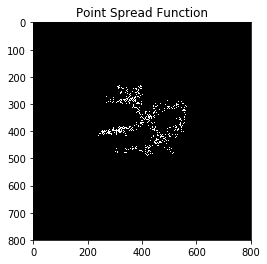

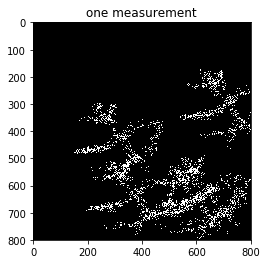

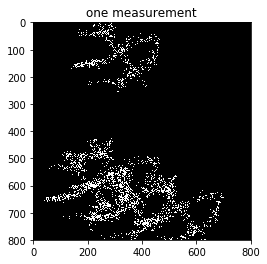

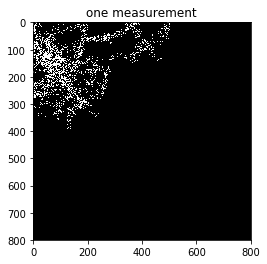

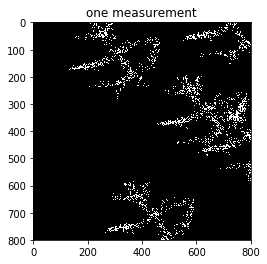

In [47]:
# Define h and v's here
h = np.asarray(Image.open('psf.png').convert('L'))
h = np.pad(h, 200, mode='constant')
plt.imshow(h, cmap = 'gray')
_ = plt.title('Point Spread Function')

points_array = np.array([
    [[343, 702],
     [679, 359],
     [699, 592],
     [469, 308],
     [665, 631]],
    [[601, 292],
     [732, 528],
     [717, 347],
     [645, 198],
     [154, 301]],
    [[266, 114],
     [182,  16],
     [113,  32],
     [235,  74],
     [ 59, 345]],
    [[756, 426],
     [463, 776],
     [367, 621],
     [ 51, 712],
     [162, 296]]
])

vs = np.zeros((4,800,800))

for i in range(len(points_array)):
    points = points_array[i]
    for point in points:
        vs[i][tuple(point)] = 1

b = generate_b(h, vs)

for i in range(4):
    plt.figure()
    plt.title('one measurement')
    _ = plt.imshow(b[i], cmap='gray')

In [48]:
H = fft.fft2(fft.ifftshift(h))
Hadj = np.conj(H)
alpha = np.real(1.8 / np.max(Hadj * H))
print('alpha: ' + str(alpha))
#alpha = 1e-12
alpha = 1e-3
h_recovered, v_recovered = gd_update(200, alpha, alpha, b, h, vs)

alpha: 5.814253497091783e-13
0th iteration
loss: 1.02e+12
10th iteration
loss: 1.28e+11
20th iteration
loss: 1.84e+10
30th iteration
loss: 4.39e+09
40th iteration
loss: 2.38e+09
50th iteration
loss: 1.93e+09
60th iteration
loss: 1.67e+09
70th iteration
loss: 1.50e+09
80th iteration
loss: 1.38e+09
90th iteration
loss: 1.30e+09
100th iteration
loss: 1.25e+09
110th iteration
loss: 1.21e+09
120th iteration
loss: 1.18e+09
130th iteration
loss: 1.16e+09
140th iteration
loss: 1.15e+09
150th iteration
loss: 1.14e+09
160th iteration
loss: 1.13e+09
170th iteration
loss: 1.13e+09
180th iteration
loss: 1.12e+09
190th iteration
loss: 1.12e+09


In [49]:
def find_points(img):
    diff = np.max(img) - np.min(img)
    return np.argwhere(img > diff/4)

def display_results(h_recovered, v_recovered):
    for i in range(len(v_recovered)):
        plt.figure()
        plt.imshow(np.real(v_recovered[i]), cmap='gray')
        plt.title('v_recovered ' + str(i))
        print(find_points(v_recovered[i]))
    
    plt.figure()
    plt.imshow(np.real(h_recovered), cmap='gray')
    plt.title('h_recovered')
    print(find_points(h_recovered))
        


[[343 702]
 [469 308]
 [665 631]
 [679 359]
 [699 592]]
[[154 301]
 [601 292]
 [645 198]
 [717 347]
 [732 528]]
[[ 59 345]
 [113  32]
 [182  16]
 [235  74]
 [266 114]]
[[ 51 712]
 [162 296]
 [367 621]
 [463 776]
 [756 426]]
[[224 392]
 [224 393]
 [224 398]
 ...
 [524 423]
 [525 412]
 [526 422]]


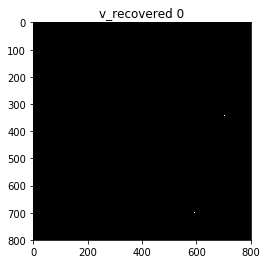

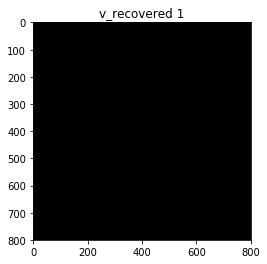

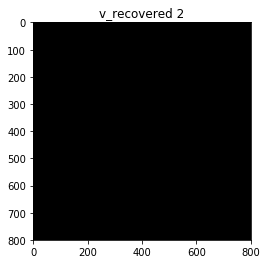

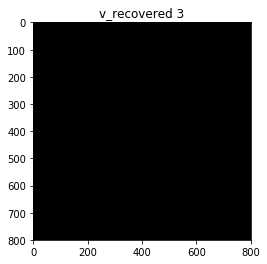

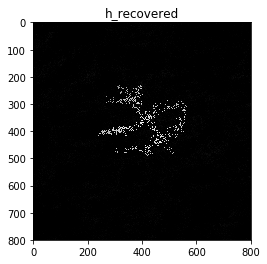

In [50]:
display_results(h_recovered, v_recovered)